<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_2_S6_file_structure.ipynb"><< Sentinel-6 file structure</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_4_S6_tracks.ipynb">Sentinel-6 tracks >></a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2022 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Ben Loveday (EUMETSAT/Innoflair UG), Hayley Evers-King (EUMETSAT), Vinca Rosmorduc (CLS)

<div class="alert alert-block alert-success">
<h3>Learn Sentinel-6: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook:
- **<a href="1_1a_S6_data_access_SFTP.ipynb" target="_blank">1_1a_S6_data_access_SFTP</a>**; this will download the required Sentinel-6 products for this notebook.

</div>
<hr>

# 1.3 Determining Sentinel-6 product coverage

### Data used

| Product Description  | Data Store collection ID| Product Navigator | 
|:--------------------:|:-----------------------:|:-------------:|
| Sentinel-6 Poseidon-4 Altimetry level-2 Low Resolution (NRT) | EO:EUM:DAT:0122 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:0122?query=Altimetry%20NRT&filter=satellite__Sentinel-6&results=20&s=advanced" target="_blank">link</a> |
| Sentinel-6 Poseidon-4 Altimetry level-2 High Resolution (NTC) | EO:EUM:DAT:0128 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:0128?query=Altimetry%20NTC&filter=satellite__Sentinel-6&results=20&s=advanced" target="_blank">link</a> |
| Sentinel-6 Poseidon-4 Altimetry level-2P High Resolution (NRT) | EO:EUM:DAT:0134 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:0134?query=Altimetry%20STC%202P&filter=satellite__Sentinel-6&results=20&s=advanced" target="_blank">link</a> |
| Sentinel-6 Poseidon-4 Altimetry level-3 High Resolution (STC) | EO:EUM:DAT:0139 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:0139?query=Wave%20STC%202P&filter=satellite__Sentinel-6&results=20&s=advanced" target="_blank">link</a> |

### Learning outcomes

At the end of this notebook you will know;
* About the 'Product Dissemination Units" that Sentinel-6 data is distributed in.
* What the Sentinel-6 PDU's look like in terms of ground coverage.
* What this means for 'revisit' time or how often you can get data for a specific area.
* How to extract the polygon which represents data coverage from and Sentinel-6 data product manifest file.
* How to visualise this data on a map.

### Outline

Whilst the Sentinel-6 satellite continuously orbit the planet, data received must be split in to manageable portions for processing and distribution. Data from the Poseidon-4 Altimeter aboard the Sentinel-6 satellite, is distributed in specific "product dissemination units" (PDUs). You can find out detailed information about the different types of PDUs and which ones are used for which Sentinel-6 products in the <a href='https://eumetsatspace.atlassian.net/wiki/spaces/DPF/pages/1615659023/Product+dissemination+units+PDUs' target='_blank'> EUMETSAT user support knowledge base </a> 

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Investigating Sentinel-6 coverage](#section1)
 2. [Investigating Sentinel-6 PDUs](#section2)
 

<hr>

In [ ]:
# library imports
import cartopy
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from shapely.geometry import Polygon
import warnings
import xml.etree.ElementTree as ET
import datetime
import xarray as xr
import glob

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 12})

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Investigating Sentinel-6 Coverage
[Back to top](#TOC_TOP)

</div>

The Poseidon-4 altimeter measures at the satellite nadir, meaning that it "views" on a thin track that matches the path of the Sentinel-6 over the Earth's surface. Sentinel-6 Michael Freilich replaces Jason-3 as the altimetry reference mission, and so inherits its orbital parameters: a non-sun synchronous orbit (non-sun synchronous to avoid being in phase with the principal components of tides) with an angle of 66° and a revisit of 10 days. It enables to sample nearly all ice-free oceans with a repetitivity high enough to monitor a large part of ocean dynamics. The figure below shows the reference tracks of the Sentinel-6 satellite, and so shows the area that Poseidon-4 samples. Due to the orbital inclination, we can see that it only samples between 66° North and South.
<img src='../img/S6_orbit.png' align='right' width='100%'/>

However, we need to decide how to distribute the data that make up these tracks. We will discuss this in the following section.

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Investigating Sentinel-6 coverage
[Back to top](#TOC_TOP)

</div>

First let's create a path that points to the location of the data files we're interesed in. We'll look at four different types of Sentinel-6 data, which will show us examples of the different types of PDUs for Poseidon-4 products. We don't always need to open the actual data files contained within the Sentinel-SAFE file in order to find out information about the products. Some information is stored in the manifest file - like the information about what area is covered by the particular data files. In the cell below, we'll find the manifest files in the directories of the products we selected above.

In [ ]:
# selecting SAFE directories
SAFE_manifests = [glob.glob(os.path.join(os.getcwd(), 'products','S6A_P4_2__LR*_NR_*','xfd*.xml'))[0],
                  glob.glob(os.path.join(os.getcwd(), 'products','S6A_P4_2__HR*_NT_*','xfd*.xml'))[0],
                  glob.glob(os.path.join(os.getcwd(), 'products','S6A_P4_2__HR*_NR_*','xfd*.xml'))[0],
                  glob.glob(os.path.join(os.getcwd(), 'products','S6A_P4_3__HR*_ST_*','xfd*.xml'))[0]]

Next, we'll look inside the manifest files and extract the polygons which represent the coverage of the data within the files.

In [ ]:
polygons = []
acq_times = []
measurement_files = []
for SAFE_manifest in SAFE_manifests:
    tree = ET.parse(SAFE_manifest)
    root = tree.getroot()
    polygon =  root.findall('.//gml:posList', {'gml':"http://www.opengis.net/gml"})
    polygons.append((polygon[0].text[:-1]))
    start_time =  root.findall('.//sentinel-safe:startTime', {'sentinel-safe':"http://www.esa.int/safe/sentinel/1.1"})
    stop_time =  root.findall('.//sentinel-safe:stopTime', {'sentinel-safe':"http://www.esa.int/safe/sentinel/1.1"})
    measurement_files.append(SAFE_manifest.replace('xfdumanifest.xml', root.findall('.//fileLocation')[0].attrib['href']))
    acq_times.append(datetime.datetime.strptime(stop_time[0].text,
                                                 "%Y-%m-%dT%H:%M:%S.%fZ")
                      - datetime.datetime.strptime(start_time[0].text,
                                                 "%Y-%m-%dT%H:%M:%S.%fZ"))

Finally, we'll plot the polygons on a world map...

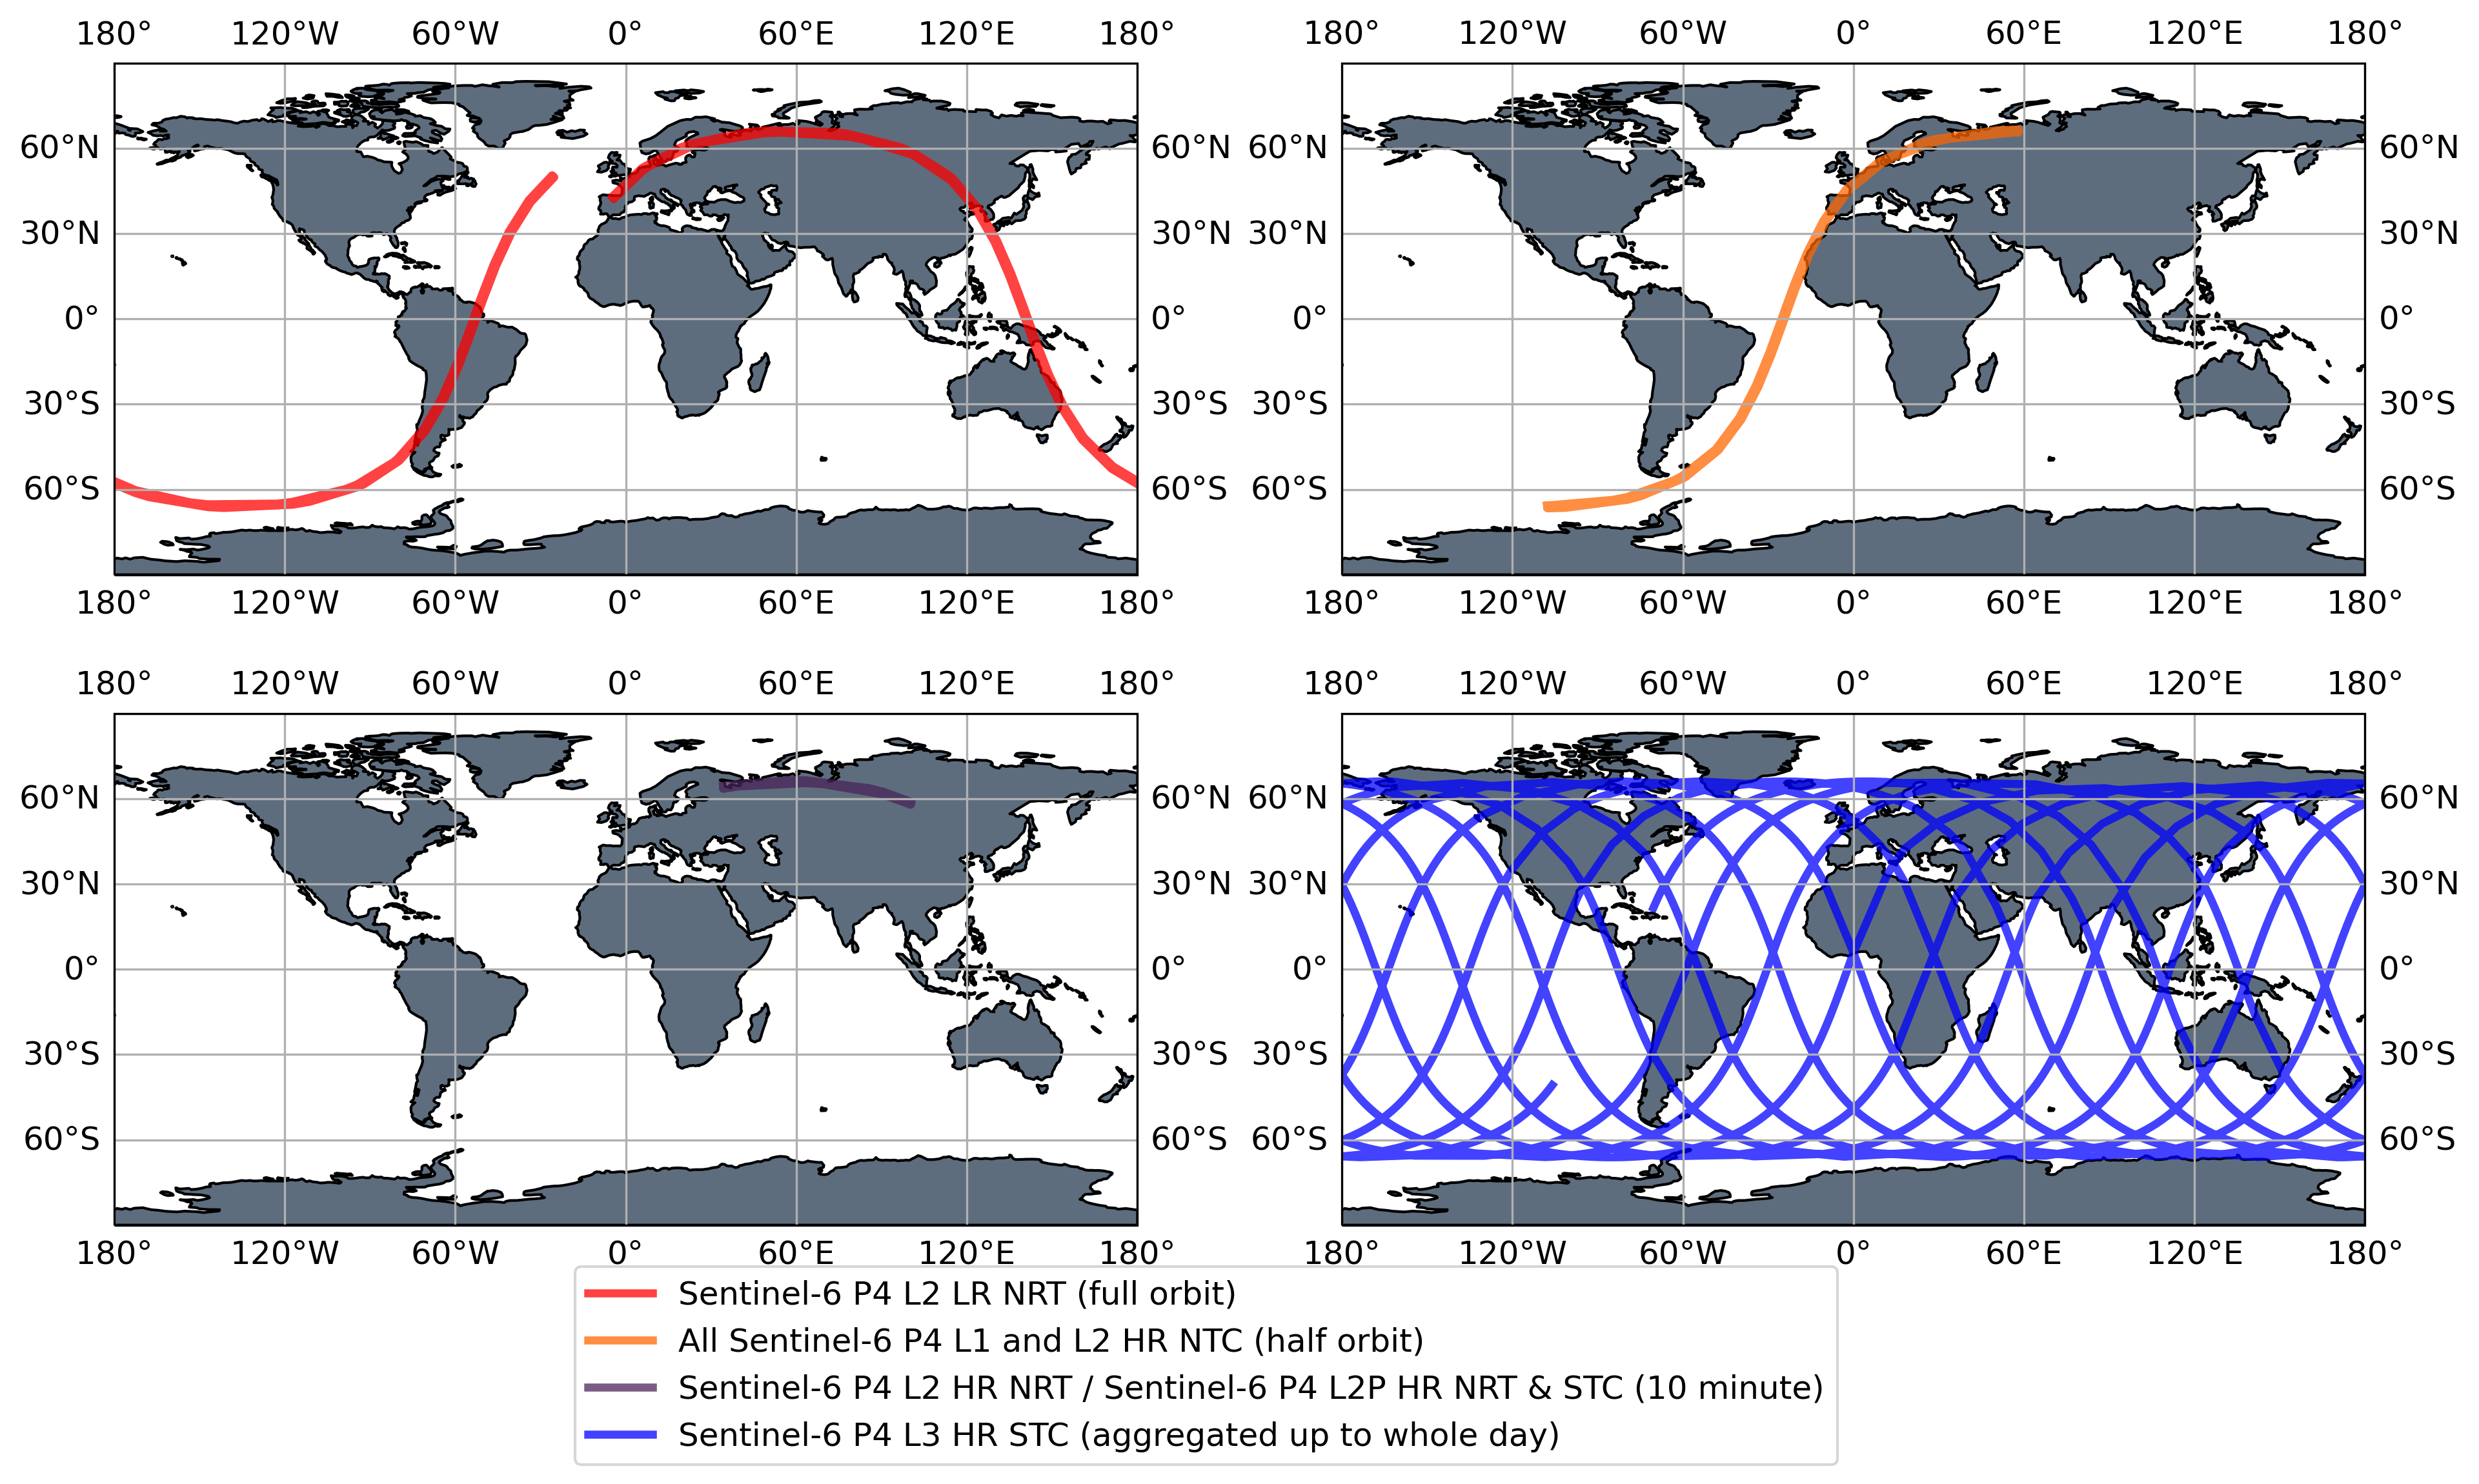

In [16]:
fig1 = plt.figure(figsize=(15, 8), dpi=300)

colours = ['#FF000000', '#FF660000', '#4A235A', '#0000FF00']
labels = ['Sentinel-6 P4 L2 LR NRT (full orbit)',
          'All Sentinel-6 P4 L1 and L2 HR NTC (half orbit)',
          'Sentinel-6 P4 L2 HR NRT / Sentinel-6 P4 L2P HR NRT & STC (10 minute)',
          'Sentinel-6 P4 L3 HR STC (aggregated up to whole day)']
plots = []

for loc, colour, label, polygon, measurement_file in zip([1, 2, 3, 4], colours, labels, polygons, measurement_files):
    m = plt.subplot(2, 2, loc, projection=cartopy.crs.PlateCarree())
    m.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
    m.set_global()

    gl = m.gridlines(draw_labels = True)
    reverse = True
    coords = np.asarray(polygon.split(' ')).astype('float')
    if 'L3' in label:
        data = xr.open_dataset(measurement_file)
        p, = m.plot(data.longitude, data.latitude, alpha=0.74, color=colour, linewidth=3, 
                    transform=cartopy.crs.Geodetic(), zorder=2)
    else:
        p, = m.plot(coords[1::2], coords[0::2], alpha=0.74, color=colour, linewidth=3, 
                    transform=cartopy.crs.Geodetic(), zorder=2)
    plots.append(p)

plt.legend(plots, labels, loc='lower right', bbox_to_anchor=(0.5, -0.5))
plt.savefig('1_3_S6_coverage.png', bbox_inches='tight')

<hr>
<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_2_S6_file_structure.ipynb"><< Sentinel-6 file structure</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_4_S6_tracks.ipynb">Sentinel-6 tracks >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>